<a href="https://colab.research.google.com/github/bryanbayup/chatbot_project/blob/main/finalisasi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and Import Additional Libraries
!pip install gensim
!pip install keras-tuner --upgrade
!pip install imbalanced-learn
!pip install Sastrawi
!pip install sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


In [2]:
# Import Libraries
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import re
import pickle
import os
import random
import nltk
import gensim
from gensim.models import KeyedVectors
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import sentencepiece as spm
from nltk.corpus import stopwords
nltk.download('stopwords')

<ipython-input-2-4f7a5e020e51>:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!wget -O id.tar.gz "https://www.dropbox.com/scl/fi/sju4o3keikox69euw51vy/id.tar.gz?rlkey=5jr3ijtbdwfahq7xcgig28qvy&e=1&st=gntzkzeo&dl=1"

In [4]:
# 1. Load Pre-trained FastText Model for Bahasa Indonesia
!tar -xzf id.tar.gz

try:
    fasttext_model = KeyedVectors.load_word2vec_format('id.vec', binary=False)
    print("Model FastText 'id.vec' berhasil dimuat.")
except Exception as e:
    print(f"Gagal memuat 'id.vec': {e}")
    raise ValueError("Gagal memuat model FastText. Pastikan file 'id.vec' dalam format yang benar.")

Model FastText 'id.vec' berhasil dimuat.


In [22]:
# 3. Preprocessing Data

# Memuat dataset dari file JSON
with open('dataaa.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Mengubah dataset menjadi DataFrame
df = pd.DataFrame(data)

# Pastikan penamaan kolom konsisten
df.rename(columns={'utterance': 'utterances', 'response': 'responses'}, inplace=True)

# Tampilkan 5 baris pertama
df.head()

,utterances,intent,entities,responses
0,Anjing saya mengalami gatal-gatal terus meneru...,medical_inquiry_dog,"[{'entity': 'animal', 'value': 'Anjing', 'star...","Gunakan sampo hipoalergenik, oleskan salep hid..."
1,Anjing saya terlihat sering muntah dan kehilan...,medical_inquiry_dog,"[{'entity': 'animal', 'value': 'Anjing', 'star...",Berikan cairan elektrolit untuk mencegah dehid...
2,"Anjing saya terlihat lesu, demam, dan tidak ma...",medical_inquiry_dog,"[{'entity': 'animal', 'value': 'Anjing', 'star...","Pastikan anjing tetap terhidrasi, gunakan komp..."
3,Anjing saya mengalami batuk kering dan nafasny...,medical_inquiry_dog,"[{'entity': 'animal', 'value': 'Anjing', 'star...",Berikan obat batuk khusus anjing yang disarank...
4,Anjing saya mengalami luka pada kulit yang men...,medical_inquiry_dog,"[{'entity': 'animal', 'value': 'Anjing', 'star...","Bersihkan luka dengan antiseptik, oleskan sale..."


In [23]:
# Menentukan jumlah sampel maksimum per intent
max_samples = 50

df_list = []
for intent in df['intent'].unique():
    df_intent = df[df['intent'] == intent]
    if len(df_intent) > max_samples:
        df_intent = df_intent.sample(n=max_samples, random_state=42)
    df_list.append(df_intent)

df_balanced = pd.concat(df_list).reset_index(drop=True)

# Encode intents
label_encoder = LabelEncoder()
df_balanced['intent_label'] = label_encoder.fit_transform(df_balanced['intent'])

# Simpan mapping label
intent_mapping = dict(zip(df_balanced['intent_label'], df_balanced['intent']))

# Mengatasi kelas imbalanced dengan oversampling
ros = RandomOverSampler(random_state=42)

X = df_balanced[['utterances', 'responses']]
y = df_balanced['intent_label']

X_ros, y_ros = ros.fit_resample(X, y)

df_balanced = X_ros.copy()
df_balanced['intent_label'] = y_ros
df_balanced['intent'] = label_encoder.inverse_transform(df_balanced['intent_label'])

# Filter data yang memiliki entitas
df_ner = df[df['entities'].map(lambda d: len(d)) > 0].reset_index(drop=True)

In [24]:
# 4. Preprocessing Text Data

# Fungsi pembersihan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Load stopwords dari 'stopword_list_tala.txt'
with open('stopword_list_tala.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().splitlines()

stop_words = set(stop_words)

# Stemming menggunakan Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    text = stemmer.stem(text)
    return text

# Terapkan preprocessing
df_balanced['utterances_clean'] = df_balanced['utterances'].apply(preprocess_text)
df_ner['utterances_clean'] = df_ner['utterances'].apply(preprocess_text)

# Siapkan teks dan label
texts = df_balanced['utterances_clean'].tolist()
labels = df_balanced['intent_label'].tolist()

# Split data untuk Klasifikasi Intent
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [27]:
# 5. Tokenisasi dan Pembuatan Embedding Matrix

# Tokenisasi
tokenizer = Tokenizer(oov_token='')
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Mengonversi teks ke sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Padding sequences
max_seq_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in val_sequences))
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_seq_length, padding='post')

# Mengonversi labels ke categorical
num_classes = len(label_encoder.classes_)
train_labels_cat = to_categorical(train_labels, num_classes=num_classes)
val_labels_cat = to_categorical(val_labels, num_classes=num_classes)

# Membuat embedding matrix menggunakan FastText
embedding_dim = fasttext_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in word_index.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

In [28]:
# 6. Persiapan Data untuk NER

def prepare_ner_data(df, tokenizer, max_seq_length):
    texts = []
    labels = []
    for index, row in df.iterrows():
        text = row['utterances_clean']
        entities = row['entities']
        tokens = tokenizer.texts_to_sequences([text])[0]
        label_seq = ['O'] * len(tokens)
        for ent in entities:
            ent_text = preprocess_text(ent['value'])
            ent_tokens = tokenizer.texts_to_sequences([ent_text])[0]
            ent_len = len(ent_tokens)
            for i in range(len(tokens) - ent_len + 1):
                if tokens[i:i+ent_len] == ent_tokens:
                    label_seq[i] = 'B-' + ent['entity']
                    for j in range(1, ent_len):
                        label_seq[i+j] = 'I-' + ent['entity']
                    break
        texts.append(tokens)
        labels.append(label_seq)
    # Padding
    texts_padded = pad_sequences(texts, maxlen=max_seq_length, padding='post')
    # Padding labels
    labels_padded = [label + ['O']*(max_seq_length - len(label)) for label in labels]
    return texts_padded, labels_padded

# Membuat label encoder untuk NER
all_labels = set()
for label_list in df_ner['entities']:
    for ent in label_list:
        all_labels.add('B-' + ent['entity'])
        all_labels.add('I-' + ent['entity'])
all_labels.add('O')
ner_label_encoder = {label: idx for idx, label in enumerate(sorted(all_labels))}
ner_label_decoder = {idx: label for label, idx in ner_label_encoder.items()}

# Siapkan data NER
texts_ner, labels_ner = prepare_ner_data(df_ner, tokenizer, max_seq_length)

# Mengonversi labels ke format numerik dan categorical
def encode_ner_labels(labels, ner_label_encoder):
    labels_encoded = []
    for label_seq in labels:
        label_ids = [ner_label_encoder[label] for label in label_seq]
        labels_encoded.append(label_ids)
    labels_encoded = np.array(labels_encoded)
    labels_encoded = to_categorical(labels_encoded, num_classes=len(ner_label_encoder))
    return labels_encoded

labels_ner_encoded = encode_ner_labels(labels_ner, ner_label_encoder)

# Split data untuk NER
train_texts_ner, val_texts_ner, train_labels_ner, val_labels_ner = train_test_split(
    texts_ner,
    labels_ner_encoded,
    test_size=0.1,
    random_state=42,
)

In [29]:
# 7. Definisi dan Kompilasi Model

from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, LSTM, TimeDistributed, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model

# Definisikan Fungsi untuk Membangun Model Klasifikasi Intent dengan CNN
def build_intent_model_with_cnn(embedding_matrix, max_seq_length, num_classes, l2_reg=0.001):
    inputs = Input(shape=(max_seq_length,))
    embedding = tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_seq_length,
        trainable=True  # Embedding layer is trainable
    )(inputs)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    global_pool = GlobalMaxPooling1D()(conv)
    dense = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(global_pool)
    dropout = Dropout(0.5)(dense)
    outputs = Dense(num_classes, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Definisikan HyperModel untuk NER
class NERHyperModel(HyperModel):
    def __init__(self, embedding_matrix, max_seq_length, num_entities):
        self.embedding_matrix = embedding_matrix
        self.max_seq_length = max_seq_length
        self.num_entities = num_entities

    def build(self, hp):
        l2_reg = hp.Choice('l2_reg', values=[1e-4, 1e-3, 1e-2])
        dropout_rate = hp.Float('dropout_rate', 0.3, 0.7, step=0.1)
        lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)

        inputs = Input(shape=(self.max_seq_length,))
        embedding = tf.keras.layers.Embedding(
            input_dim=self.embedding_matrix.shape[0],
            output_dim=self.embedding_matrix.shape[1],
            weights=[self.embedding_matrix],
            input_length=self.max_seq_length,
            trainable=True
        )(inputs)
        lstm = Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(l2_reg), return_sequences=True))(embedding)
        dropout = Dropout(dropout_rate)(lstm)
        outputs = TimeDistributed(Dense(self.num_entities, activation='softmax'))(dropout)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [30]:
# 8. Pelatihan Model Klasifikasi Intent

model_intent_cnn = build_intent_model_with_cnn(embedding_matrix, max_seq_length, num_classes, l2_reg=0.001)
model_intent_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_intent_cnn.summary()

# Early stopping
callbacks_intent = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Pelatihan model
history_intent_cnn = model_intent_cnn.fit(
    train_padded,
    train_labels_cat,
    validation_data=(val_padded, val_labels_cat),
    epochs=20,
    batch_size=16,
    callbacks=callbacks_intent
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 embedding (Embedding)       (None, 21, 300)           169200    
                                                                 
 conv1d (Conv1D)             (None, 19, 128)           115328    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

In [31]:
# 9. Hyperparameter Tuning untuk Model NER

# Inisialisasi HyperModel
ner_hypermodel = NERHyperModel(embedding_matrix, max_seq_length, len(ner_label_encoder))

# Inisialisasi RandomSearch
tuner_ner = RandomSearch(
    ner_hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='ner_tuner_dir',
    project_name='ner_tuning'
)

# Pencarian Hyperparameters untuk NER
tuner_ner.search(
    train_texts_ner,
    train_labels_ner,
    epochs=10,
    validation_data=(val_texts_ner, val_labels_ner),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Mendapatkan model terbaik untuk NER
best_model_ner = tuner_ner.get_best_models(num_models=1)[0]
best_hp_ner = tuner_ner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters for NER: {best_hp_ner.values}")

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.9211309552192688

Best val_accuracy So Far: 0.945684552192688
Total elapsed time: 00h 02m 22s
Best Hyperparameters for NER: {'l2_reg': 0.0001, 'dropout_rate': 0.3, 'lstm_units': 128}


17/17 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9615
Akurasi Model Klasifikasi Intent: 96.15%
17/17 [==============================] - 0s 3ms/step
Classification Report untuk Intent:
                              precision    recall  f1-score   support

         animal_health_issue       1.00      1.00      1.00        10
              cat_healthcare       0.91      1.00      0.95        10
      disease_prevention_cat       1.00      1.00      1.00        10
      disease_prevention_dog       1.00      1.00      1.00        10
              dog_healthcare       0.91      1.00      0.95        10
                    end_chat       1.00      1.00      1.00        10
  found_abandoned_dog_street       1.00      1.00      1.00        10
       found_abandoned_puppy       1.00      1.00      1.00        10
                found_animal       0.73      0.80      0.76        10
           found_barking_dog       1.00      1.00      1.00        10
       found

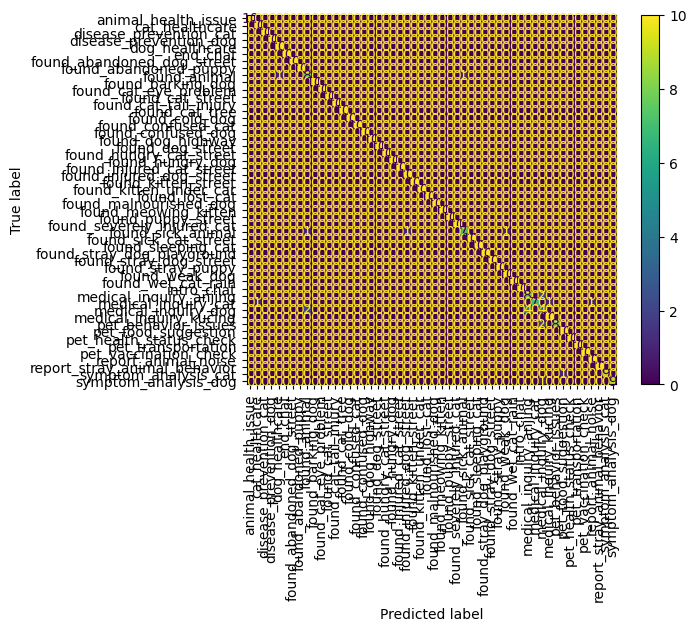

In [32]:
# 10. Evaluasi Model Klasifikasi Intent

loss_intent, accuracy_intent = model_intent_cnn.evaluate(val_padded, val_labels_cat)
print(f'Akurasi Model Klasifikasi Intent: {accuracy_intent * 100:.2f}%')

# Prediksi pada data validasi Intent
val_preds_intent = model_intent_cnn.predict(val_padded)
val_preds_intent = np.argmax(val_preds_intent, axis=1)
val_true_intent = np.argmax(val_labels_cat, axis=1)

# Classification report untuk Intent
print("Classification Report untuk Intent:")
print(classification_report(val_true_intent, val_preds_intent, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(val_true_intent, val_preds_intent)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation='vertical')
plt.show()

In [36]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=d0ef525814afa0148f76fdcc62db902658e7fdd37a794a75f6c4bade00665280
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [37]:
import seqeval
from seqeval.metrics import classification_report as seq_classification_report

In [38]:
# 11. Evaluasi Model NER

loss_ner, accuracy_ner = best_model_ner.evaluate(val_texts_ner, val_labels_ner)
print(f'Akurasi Model NER: {accuracy_ner * 100:.2f}%')

# Prediksi pada data validasi NER
val_preds_ner = best_model_ner.predict(val_texts_ner)
val_preds_ner = np.argmax(val_preds_ner, axis=-1)
val_true_ner = np.argmax(val_labels_ner, axis=-1)

# Konversi label ke format aslinya
true_labels = []
pred_labels = []

for i in range(len(val_preds_ner)):
    true_label = []
    pred_label = []
    for j in range(len(val_preds_ner[i])):
        true_l = ner_label_decoder[val_true_ner[i][j]]
        pred_l = ner_label_decoder[val_preds_ner[i][j]]
        if true_l != 'O':
            true_label.append(true_l)
            pred_label.append(pred_l)
    true_labels.append(true_label)
    pred_labels.append(pred_label)

# Classification report untuk NER
print("Classification Report untuk NER:")
print(seq_classification_report(true_labels, pred_labels))

2/2 [==============================] - 0s 15ms/step - loss: 0.2247 - accuracy: 0.9457
Akurasi Model NER: 94.57%
2/2 [==============================] - 0s 29ms/step
Classification Report untuk NER:
              precision    recall  f1-score   support

      animal       0.95      0.98      0.96        54
    behavior       0.00      0.00      0.00         1
   condition       0.33      0.29      0.31         7
     disease       0.86      0.67      0.75         9
    duration       0.00      0.00      0.00         1
        food       0.00      0.00      0.00         2
    location       0.53      0.64      0.58        14
       sound       0.00      0.00      0.00         1
     symptom       0.51      0.51      0.51        81
     trigger       0.00      0.00      0.00         1
     vaccine       0.00      0.00      0.00         1

   micro avg       0.66      0.65      0.65       172
   macro avg       0.29      0.28      0.28       172
weighted avg       0.64      0.65      0.64  

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# 12. Simpan Model dan Encoder

# Simpan model intent
model_intent_cnn.save('models/model_intent.keras')

# Simpan model NER
best_model_ner.save('models/model_ner.keras')

# Simpan tokenizer
with open('encoders/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Simpan label encoder
with open('encoders/label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Simpan NER label encoder
with open('encoders/ner_label_encoder.pickle', 'wb') as handle:
    pickle.dump(ner_label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# 13. Membuat DataFrame untuk Respon

# Membuat DataFrame utterances dan responses
df_utterances = df_balanced[['utterances', 'responses']].reset_index(drop=True)
df_utterances['utterances_clean'] = df_utterances['utterances'].apply(preprocess_text)

# Simpan DataFrame df_utterances
df_utterances.to_pickle('data/df_utterances.pkl')

In [44]:
# 14. Membuat Fungsi Chatbot

import random
from sklearn.feature_extraction.text import TfidfVectorizer

# Membuat TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_utterances['utterances_clean'])

# Simpan vectorizer dan TF-IDF matrix
with open('data/vectorizer.pickle', 'wb') as handle:
    pickle.dump(vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('data/tfidf_matrix.pickle', 'wb') as handle:
    pickle.dump(tfidf_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

def predict_intent(text):
    text_clean = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded_seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    pred = model_intent_cnn.predict(padded_seq)
    predicted_label = np.argmax(pred, axis=1)[0]
    intent = label_encoder.inverse_transform([predicted_label])[0]
    return intent

def predict_entities(text):
    text_clean = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([text_clean])
    padded_seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    pred = best_model_ner.predict(padded_seq)
    pred_labels = np.argmax(pred, axis=-1)[0]
    tokens = tokenizer.sequences_to_texts(seq)[0].split()
    entities = []
    for idx, label_id in enumerate(pred_labels[:len(tokens)]):
        label = ner_label_decoder[label_id]
        if label != 'O':
            entities.append({'entity': label.split('-')[1], 'value': tokens[idx]})
    return entities

def fill_slots(template, entities):
    slot_values = {ent['entity']: ent['value'] for ent in entities}
    response = template.format(**slot_values)
    return response

def get_response(user_input, intent=None, entities=None):
    user_input_clean = preprocess_text(user_input)
    user_tfidf = vectorizer.transform([user_input_clean])
    similarities = cosine_similarity(user_tfidf, tfidf_matrix)
    most_similar_idx = np.argmax(similarities[0])
    highest_similarity = similarities[0][most_similar_idx]

    # Daftar pesan default
    default_responses = [
        "Maaf, saya belum bisa menjawab pertanyaan Anda.",
        "Maaf, mohon diperjelas apa yang Anda maksud.",
        "Maaf, saya hanya diprogram untuk menjawab penyakit dan pertolongan pertama pada hewan kucing dan anjing.",
        "Mohon maaf, saya tidak mengerti. Bisa dijelaskan lebih detail?",
        "Saya belum memiliki informasi mengenai hal tersebut."
    ]

    if highest_similarity < 0.35:
        return random.choice(default_responses)
    else:
        # Ambil respon yang sesuai
        response = df_utterances.iloc[most_similar_idx]['responses']
        return response

def chatbot_response(user_input):
    # Prediksi intent dan entitas
    intent = predict_intent(user_input)
    entities = predict_entities(user_input)

    # Respon
    response = get_response(user_input, intent, entities)

    return response

In [45]:
# 15. Implementasi K-Fold Cross-Validation untuk Klasifikasi Intent

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in skf.split(train_padded, np.argmax(train_labels_cat, axis=1)):
    X_train_fold, X_test_fold = train_padded[train_index], train_padded[test_index]
    y_train_fold, y_test_fold = train_labels_cat[train_index], train_labels_cat[test_index]

    # Bangun dan latih model untuk setiap fold
    model = build_intent_model_with_cnn(embedding_matrix, max_seq_length, num_classes)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=16, verbose=0)
    loss, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    accuracies.append(accuracy)

print(f"Rata-rata akurasi dari 5-Fold Cross-Validation: {np.mean(accuracies) * 100:.2f}%")

Rata-rata akurasi dari 5-Fold Cross-Validation: 94.71%


In [47]:
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Membuat widget input dan output
input_box = widgets.Text(
    value='',
    placeholder='Ketik pesan Anda...',
    description='Anda:',
    disabled=False
)

output_area = widgets.Output()

def on_submit(sender):
    user_input = input_box.value
    input_box.value = ''
    response = chatbot_response(user_input)
    with output_area:
        clear_output()
        print(f"Anda: {user_input}")
        print(f"Chatbot: {response}\n")

input_box.on_submit(on_submit)

display(input_box, output_area)

Text(value='', description='Anda:', placeholder='Ketik pesan Anda...')

Output()

1/1 [==============================] - 0s 25ms/step
